In [1]:
# Import required libraries
import numpy as np
from scipy.linalg import expm, logm, sqrtm
import matplotlib.pyplot as plt
import h5py
import os
import seaborn as sns
import pandas as pd

# Working directories
script_dir = os.path.dirname(os.path.realpath("__file__"))
data_dir = script_dir
graphs_dir = os.path.join(script_dir, 'Graphs/')

print(os.listdir(data_dir))

['N_6__m_3__model_Ising__ansatz_Ising__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_3__multiE_no__geom_normal__sym_GPU__h1_1__h2_None', 'N_6__m_6__model_Ising__ansatz_Ising__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_9__multiE_no__geom_normal__sym_GPU__h1_1__h2_None', 'N_6__m_6__model_Heisenberg__ansatz_Heist-single__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_5__multiE_no__geom_normal__sym_GPU__h1_1__h2_None', 'N_6__m_6__model_Heisenberg__ansatz_Heist-single__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_1__multiE_no__geom_normal__sym_GPU__h1_1__h2_None', 'N_6__m_3__model_Ising__ansatz_Ising__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__o

In [2]:
def calculate_fidelity( rho,rho_target):
        '''
        Calculates the (Uhlmann-Jozsa) fidelity between the quantum circuit state and the target one.
        :param rho: density matrix of the current iteration state
        :return: the fidelity (double)
        '''
        w, v = np.linalg.eigh(rho_target)

        rho_target_sqrt = (v * np.sqrt(np.maximum(w, 0))).dot(v.conj().T)

        mat = np.matmul(np.matmul(rho_target_sqrt, rho), rho_target_sqrt)
        # F = np.trace(sqrtm(mat)) **2  # computed with different libraries, should give the same
        F = np.sum(np.sqrt(np.clip(np.linalg.eigh(mat)[0].real, 0, 1))) ** 2
        return F
def read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror, n_shots = None,  p_err = 0.01,tol = 1e-5,initZ = "random-Gaussian-small",format="Kristina",sym_method = "CPU",h1 = 0,h2 = 0):
    grid_dir = os.path.join(data_dir, "N={}_m={}_model={}_ansatz={}_initialization=random-gaussian_errorChannel={}_p_err={}_entropyMethod={}_optimizer={}_tol_1e-08_nShots={}_seed={}_multierror={}_geom_normal/".format(
            N, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
            m, #N_3__m_2__model_HDm2__ansatz_qaoa-r-layers__initialization_random-gaussian__errorChannel_phaseflip__p_err_0.01__entropyMethod_exact__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_5__multierror_no__geom_normal
        #
            model,
            ansatz,
            error_channel,
            p_err,
            entropy_method,
            optimizer,
            n_epochs,
            n_fev,
            n_shots,
            seed,
            multierror
        ))
    
    if format == "Kristina":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initialization_random-gaussian"+'__errorChannel_'+str(error_channel)+'__p_err_0.01__entropyMethod_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+'__multierror_'+str(multierror) + "__geom_normal/")
    elif format == "truncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "shortend":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_1e-08__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal/")
    elif format == "shortendtruncSeed":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_random-gaussian"+'__errorC_'+str(error_channel)+'__p_err_0.01__entropyM_'+str(entropy_method)+'__optimizer_'+str(optimizer)+'__tol_1e-08__nShots_None__seed_'+str(seed)+ "/")
    elif format == "full":
        grid_dir = os.path.join(data_dir, 'N_'+str(N)+'__m_'+str(m)+'__model_'+str(model)+'__ansatz_'+str(ansatz)+"__initZ_"+str(initZ)+'__errorC_'+str(error_channel)+'__p_err_'+str(p_err)+'__entropyM_'+str(entropy_method)+'__optimizer_L-BFGS-B__tol_'+str(tol)+'__nShots_None__seed_'+str(seed)+ "__multiE_no__geom_normal"+"__sym_" +str(sym_method)+"__h1_"+str(h1)+"__h2_"+str(h2)+"/")
    elif format == "GPU_full":
        grid_dir = os.path.join(data_dir, f'N_{N}__m_{m}__model_{model}__ansatz_{ansatz}__initZ_random-gaussian-small__errorC_{error_channel}__p_err_{p_err}__entropyM_{entropy_method}__optimizer_L-BFGS-B__tol_'+str(tol)+'__nShots_None__seed_'+str(seed)+'__multiE_no__geom_normal__sym_GPU/')
    
    #elif format == "full":
    #    grid_dir = os.path.join(data_dir, f'N_{N}__m_{m}__model_{model}__ansatz_{ansatz}__initZ_random-gaussian-small__errorC_{error_channel}__p_err_{p_err}__entropyM_{entropy_method}__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_{seed}__multiE_False__geom_normal__sym_CPU/')

    #'N-'+str(N)+'--m-'+str(m)+'--model-'+str(model)+'--ansatz-'+str(ansatz)+"--initialization-random-gaussian"+'--errorChannel-'+str(error_channel)+'--p_err-0.01--entropyMethod-'+str(entropy_method)+'--optimizer-L-BFGS-B--tol-1e-08--nShots-None--seed-'+str(seed)+'--multierror-'+str(multierror) + "--geom-normal/")
    files = []
    if os.path.exists(grid_dir):
        files = os.listdir(grid_dir)
        hdf5_files = [f for f in files if not f.endswith('.txt')]
        data = []
        print(hdf5_files)
        for file_num, filename in enumerate(hdf5_files): 
            f = h5py.File(grid_dir + str(filename), 'r')
            
            
            row = []
            for grp in f.keys():
                settings = f[grp].attrs['Settings']
                #print(settings)
            
                beta = grp
                
                #F_best = f[grp]['F'].attrs['F_best'] 
                #F_last = f[grp]['F'][:][-1]
                rho_target = f[grp]['rho_target'][:]
                rho_final = f[grp]['rho_final'][:]
                #Check no nans:
                if not np.any(np.isnan(rho_final)):
                    row.append(beta) 
                    row.append(N)
                    row.append(m)
                    row.append(model)
                    row.append(ansatz) 
                    row.append(error_channel) 
                    row.append(entropy_method) 
                    row.append(optimizer) 
                    row.append(n_epochs)
                    row.append(n_fev) 
                    row.append(seed) 
                    row.append(multierror) 
                    #row.append(float(F_best))
                    row.append(float(calculate_fidelity(rho_target,rho_final)))
            
                    S_cross = np.real(-np.trace(np.dot(rho_final, logm(rho_target))))
                    #print(S_cross)
                    S_target = np.real(-np.trace(np.dot(rho_target, logm(rho_target))))
                    #print(S_target)
                    S_cross_scaled = S_cross / S_target
                    S_cross_diff = np.abs(S_cross - S_target)
                    
                    row.append(float(S_cross_scaled))
                    row.append(float(S_cross_diff))
                    #print(S_cross_scaled)
                    #print(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))))
                        
                    #S_HS = np.trace(np.dot(rho_final, rho_target)) / np.max(np.real(np.trace(np.linalg.matrix_power(rho_final, 2))), np.real(np.trace(np.linalg.matrix_power(rho_target, 2))))
                    #print(S_HS)
                    
                    TD = np.trace(sqrtm(np.linalg.matrix_power(rho_final - rho_target, 2))) / 2
                    
                    row.append(np.real(TD))
                    
                    #row.append(np.shape(f[grp]['F'][:])[0])
                    row.append(f[grp]["G"][-1])
                    row.append(h1)
                    if h2:
                        row.append(h2)
                    else: row.append(0)
                    """Beta_arr
                    if not f[grp]["G"]:
                        row.append(f[grp]["G"][-1])
                    else:
                        row.append(0)
                    """

                    data.append(row)
        if not data: return None
        df = pd.DataFrame(np.array(data), columns=['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method', 'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror','F', 'S_cross', 'S_cross_diff', 'TD',"FinalCost","h1","h2"])#
        return df
    else: 
            print(f"Directory {grid_dir} does not exist.")

    
            
    


In [3]:

def create_data_frame(frames):
        df = pd.concat(frames, ignore_index=True)

        df['beta']= df['beta'].astype(float)
        df['N']= df['N'].astype(int)
        df['m']= df['m'].astype(int)
        df['model']= df['model'].astype(str)
        df['ansatz']= df['ansatz'].astype(str)
        df['error_channel']= df['error_channel'].astype(str)
        df['entropy_method']= df['entropy_method'].astype(str)
        df['optimizer']= df['optimizer'].astype(str)
        df['n_epochs']= df['n_epochs'].astype(str)
        df['n_fev']= df['n_fev'].astype(str)
        df['seed']= df['seed'].astype(int)
        df['multierror']= df['multierror'].astype(str)
        df['F']= df['F'].astype(float)
        df['S_cross']= df['S_cross'].astype(float)
        
        df['S_cross_diff']= df['S_cross_diff'].astype(float)
        df['TD']= df['TD'].astype(float)
        #df['Nit']= df['Nit'].astype(float)
        df['FinalCost']= df['FinalCost'].astype(float)
        df["h1"]=df['h1'].astype(float)
        df["h2"]=df['h2'].astype(float)

        return df

Now plot the hardest point: ,h1 = 0.33,h2 = -0.11
Mistakenly set it to nine layers

Another try larger system:

In [4]:

beta_arr =  np.around(np.exp(np.linspace(np.log(0.75),np.log(20),10)),decimals = 2)#[0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#[  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#


frames = []

N_list = [6]
m_list = [6]
model_list = ["TFC"]
ansatz_list = ["TFC-sym3qubit","TFC-sym"]#[::1]#
error_channel_list = ["phaseflip"]
entropy_method_list = ["exact"]
optimizer_list = ["L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5]#
multierror_list = ["no"]
initZ = "random-gaussian-small"
perr = 1e-5

h1 = 0
h2 = 0
for N in N_list:
    for m in m_list:  
                for model in model_list:
                    for ansatz in ansatz_list:
                        for error_channel in error_channel_list:
                            for entropy_method in entropy_method_list:
                                for optimizer in optimizer_list:
                                    for n_epochs in n_epochs_list:
                                        for n_fev in n_fev_list:
                                            for seed in seeds:
                                                for multierror in multierror_list:
                                                                entropy_method = "exact"
                                                                sym_method ="GPU"
                                                                frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,p_err = 1e-5,tol = 1e-10,initZ=initZ,format = "GPU_full",sym_method=sym_method,h1 = h1,h2 = h2))
                                                  
                        
df = create_data_frame(frames)
df
#N_6__m_6__model_TFC__ansatz_TFC-sym3qubit__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_2__multiE_no__geom_normal__sym_GPU
#N_6__m_6__model_TFC__ansatz_TFC-sym3qubit__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_1__multiE_False__geom_normal__sym_GPU/ 

['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', 

,beta,N,m,model,ansatz,error_channel,entropy_method,optimizer,n_epochs,n_fev,seed,multierror,F,S_cross,S_cross_diff,TD,FinalCost,h1,h2
0,6.69,6,6,TFC,TFC-sym3qubit,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.999988,5.089851e+00,0.000545,2.049707e-05,-40.139694,0.0,0.0
1,3.23,6,6,TFC,TFC-sym3qubit,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.999989,9.980749e-01,0.000135,7.316500e-05,-19.389298,0.0,0.0
2,1.08,6,6,TFC,TFC-sym3qubit,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.999999,1.000019e+00,0.000037,3.030948e-04,-7.134874,0.0,0.0
3,2.24,6,6,TFC,TFC-sym3qubit,phaseflip,exact,L-BFGS-B,50,10000,1,no,1.000000,9.999581e-01,0.000015,8.519092e-05,-13.507618,0.0,0.0
4,0.75,6,6,TFC,TFC-sym3qubit,phaseflip,exact,L-BFGS-B,50,10000,1,no,1.000000,1.000001e+00,0.000002,6.696650e-07,-5.708480,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.64,6,6,TFC,TFC-sym,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.999979,1.363226e+03,0.000702,9.306647e-04,-57.839197,0.0,0.0
96,4.65,6,6,TFC,TFC-sym,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.999642,3.193191e-01,0.003846,9.526020e-04,-27.899516,0.0,0.0
97,13.89,6,6,TFC,TFC-sym,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.999975,5.767446e+06,0.000858,4.491690e-04,-83.338617,0.0,0.0
98,20.00,6,6,TFC,TFC-sym,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.999979,-8.434256e+10,0.000811,1.095522e-03,-119.998137,0.0,0.0


FileNotFoundError: [Errno 2] No such file or directory: '/Users/eliaszap/polybox - Elias Zapusek (zapuseke@phys.ethz.ch)@polybox.ethz.ch/Phd/QML/VQT/Data_grid/Data_01_09/Graphs/TFC_exact.png'

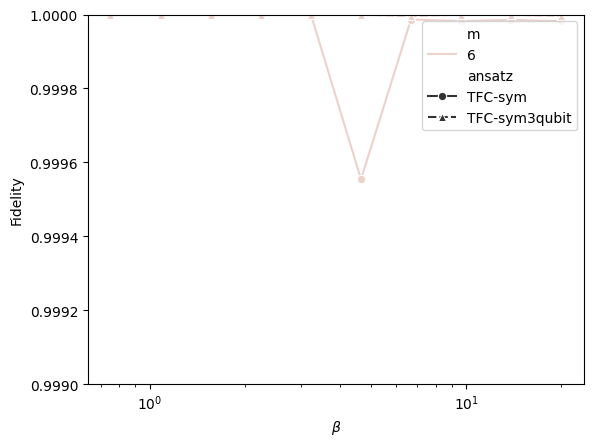

In [5]:
# plot
beta_arr = np.around(np.exp(np.linspace(np.log(0.75),np.log(20),10)),decimals = 2)#[0.01 ,0.05, 0.1,0.2, 0.25,0.3, 0.5,0.75,1.5, 0.75, 1, 2, 5, 10,20]
df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['FinalCost'].idxmin()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

sns.lineplot(data = df_max, x = 'beta', y ='F', style="ansatz",hue = "m", markers=['o',"^"],)
plt.xscale('log')
plt.ylim(0.999,1)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

filename = "TFC_exact.png"  
plt.savefig(graphs_dir + filename, bbox_inches='tight')
plt.show()
# plot
print("maximum Fidelity")

df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['F'].idxmax()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

sns.lineplot(data = df_max, x = 'beta', y ='F', style="ansatz",hue = "m",  markers=['o',"^"],)
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

plt.show()

print("average")
sns.lineplot(data = df, x = 'beta', y ='F', style="ansatz",hue = "m", markers=['o',"^"],)
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')


Now TFIM 

In [31]:
unique_h1_values = [1]#[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
unique_h2_values = "None"

beta_arr =  np.around(np.exp(np.linspace(np.log(0.75),np.log(20),10)),decimals = 2)#[  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#[  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#
h_arr = np.linspace(-1,1,10)[2:]

frames = []

N_list = [6]
m_list = [9]
model_list = ["TFIM"]
ansatz_list = ["sym_TFIM","TFIM-trotter"]#[::1]#,#"sym-TFIM-multi",
error_channel_list = ["phaseflip"]
entropy_method_list = ["exact"]
optimizer_list = ["L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5]#,3,4,5,6,7,8
multierror_list = ["no"]
initZ = "random-gaussian-small"
perr = 1e-5



for N in N_list:
    for m in m_list:  
                for model in model_list:
                    for ansatz in ansatz_list:
                        for error_channel in error_channel_list:
                            for entropy_method in entropy_method_list:
                                for optimizer in optimizer_list:
                                    for n_epochs in n_epochs_list:
                                        for n_fev in n_fev_list:
                                            for seed in seeds:
                                                for multierror in multierror_list:
                                                    for h1 in unique_h1_values:
                                                                h2 = None
                                                                entropy_method = "exact"
                                                                sym_method ="GPU"
                                                                frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,p_err = 1e-5,tol = 1e-10,initZ=initZ,format = "full",sym_method=sym_method,h1 = h1,h2 = h2))
                                                  
                        
df = create_data_frame(frames)
df
#N_6__m_9__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-05__nShots_None__seed_5__multiE_no__geom_normal__sym_GPU__h1_1__h2_None
#N_6__m_9__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_1__multiE_no__geom_normal__sym_GPU__h1_1__h2_None/ 

['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', '[20.0]', '[1.56]']
['[6.69]', '[3.23]', '[1.08]', '[2.24]', '[0.75]', '[9.64]', '[4.65]', '[13.89]', 

,beta,N,m,model,ansatz,error_channel,entropy_method,optimizer,n_epochs,n_fev,seed,multierror,F,S_cross,S_cross_diff,TD,FinalCost,h1,h2
0,6.69,6,9,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.858325,0.382977,0.257167,0.146552,-51.696275,1.0,0.0
1,3.23,6,9,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.853825,0.944319,0.034778,0.260132,-25.022018,1.0,0.0
2,1.08,6,9,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.968859,1.145668,0.220634,0.131691,-9.054759,1.0,0.0
3,2.24,6,9,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.890612,1.256951,0.190156,0.250531,-17.500527,1.0,0.0
4,0.75,6,9,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.991224,1.041166,0.092887,0.074289,-6.899320,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.64,6,9,TFIM,TFIM-trotter,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.929778,0.293848,0.184932,0.073185,-74.491957,1.0,0.0
96,4.65,6,9,TFIM,TFIM-trotter,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.823663,0.555940,0.238384,0.222925,-35.939887,1.0,0.0
97,13.89,6,9,TFIM,TFIM-trotter,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.977657,0.232920,0.090106,0.025065,-107.332479,1.0,0.0
98,20.00,6,9,TFIM,TFIM-trotter,phaseflip,exact,L-BFGS-B,50,10000,5,no,0.995315,0.189527,0.026100,0.005136,-154.546293,1.0,0.0


In [62]:
df_max[df_max['beta']==6.69 ]#6.69 

,beta,N,m,model,ansatz,error_channel,entropy_method,optimizer,n_epochs,n_fev,seed,multierror,F,S_cross,S_cross_diff,TD,FinalCost,h1,h2
60,6.69,6,9,TFIM,TFIM-trotter,phaseflip,exact,L-BFGS-B,50,10000,2,no,0.867659,0.390906,0.253863,0.146170,-51.697584,1.0,0.0
0,6.69,6,9,TFIM,sym_TFIM,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.858325,0.382977,0.257167,0.146552,-51.696275,1.0,0.0


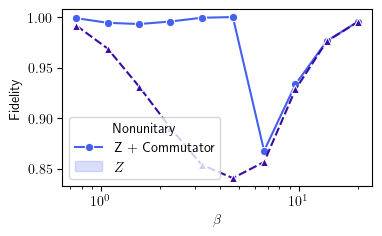

maximum Fidelity


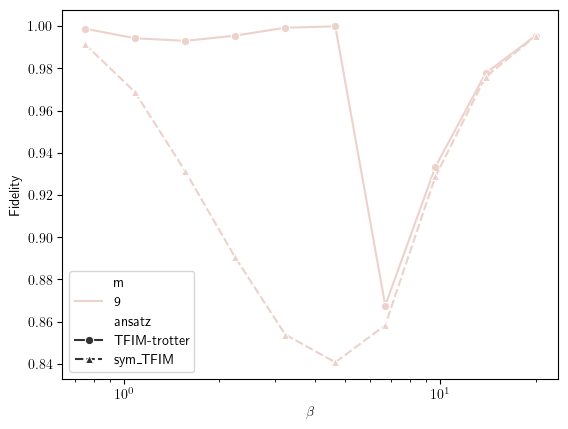

average


Text(0, 0.5, 'Fidelity')

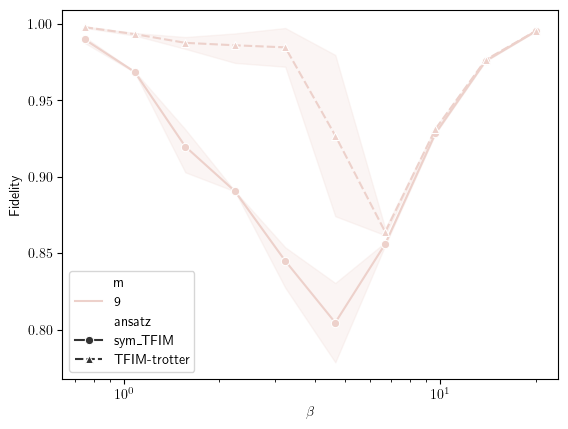

In [56]:
# plot

beta_arr =  np.around(np.exp(np.linspace(np.log(0.75),np.log(20),10)),decimals = 2)#[0.01 ,0.05, 0.1,0.2, 0.25,0.3, 0.5,0.75,1.5, 0.75, 1, 2, 5, 10,20]
df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['FinalCost'].idxmin()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

palette = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]
plt.rcParams['text.usetex'] = True

plt.figure(figsize=(4,2.3))
sns.lineplot(data = df_max, x = 'beta', y ='F', style="ansatz",hue="ansatz", markers=['o', '^'],palette=[palette[3],palette[2]])
plt.xscale('log')
#plt.ylim(0.8,1)
plt.legend(title='Nonunitary', labels=[r'Z'+' + Commutator', r'$Z$'])
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

filename = "TFIM_exact.pdf"
plt.savefig(filename, bbox_inches='tight', facecolor=(1,1,1,0))
plt.show()
# plot
print("maximum Fidelity")

df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['F'].idxmax()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

sns.lineplot(data = df_max, x = 'beta', y ='F', style="ansatz",hue = "m",  markers=['o', '^'],)#,'.'
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

plt.show()

print("average")
sns.lineplot(data = df, x = 'beta', y ='F', style="ansatz",hue = "m", markers=['o', '^'],)
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')


In [10]:
#Heisenberg woth transverse field 
unique_h1_values = [1]#[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
unique_h2_values = "None"

beta_arr =  np.around(np.exp(np.linspace(np.log(0.01),np.log(10),10)),decimals = 2)
h_arr = [1]

frames = []

N_list = [6]
m_list = [6]# also have 3
model_list = ["Ising"]
ansatz_list = ["Ising","Ising-multi"]#[::1]#,
error_channel_list = ["phaseflip"]
entropy_method_list = ["exact"]
optimizer_list = ["L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5,6,7,8]#
multierror_list = ["no"]
initZ = "random-gaussian-small"
perr = 1e-5



for N in N_list:
    for m in m_list:  
                for model in model_list:
                    for ansatz in ansatz_list:
                        for error_channel in error_channel_list:
                            for entropy_method in entropy_method_list:
                                for optimizer in optimizer_list:
                                    for n_epochs in n_epochs_list:
                                        for n_fev in n_fev_list:
                                            for seed in seeds:
                                                for multierror in multierror_list:
                                                    for h1 in unique_h1_values:
                                                                h2 = None
                                                                entropy_method = "exact"
                                                                sym_method ="GPU"
                                                                frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,p_err = 1e-5,tol = 1e-5,initZ=initZ,format = "full",sym_method=sym_method,h1 = h1,h2 = h2))
                                                  
                        
df = create_data_frame(frames)
df



['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']


/Users/eliaszap/anaconda3/envs/qutip-env/lib/python3.8/site-packages/scipy/linalg/_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)


['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]', '[0.46]', '[0.01]', '[0.1]', '[0.02]', '[4.64]', '[1.0]', '[10.0]', '[0.22]', '[2.15]']
['[0.05]',

,beta,N,m,model,ansatz,error_channel,entropy_method,optimizer,n_epochs,n_fev,seed,multierror,F,S_cross,S_cross_diff,TD,FinalCost,h1,h2
0,0.05,6,6,Ising,Ising,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.991856,1.007856e+00,0.032540,0.070784,-4.158715,1.0,0.0
1,0.46,6,6,Ising,Ising,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.930448,8.799442e-01,0.238281,0.128987,-5.938734,1.0,0.0
2,0.01,6,6,Ising,Ising,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.999695,1.000293e+00,0.001218,0.013322,-4.158883,1.0,0.0
3,0.10,6,6,Ising,Ising,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.965665,1.034254e+00,0.139944,0.149527,-4.158861,1.0,0.0
4,0.02,6,6,Ising,Ising,phaseflip,exact,L-BFGS-B,50,10000,1,no,0.998764,1.001190e+00,0.004947,0.027031,-4.158883,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,4.64,6,6,Ising,Ising-multi,phaseflip,exact,L-BFGS-B,50,10000,8,no,0.999728,5.717405e+07,0.008029,0.006978,-55.674499,1.0,0.0
156,1.00,6,6,Ising,Ising-multi,phaseflip,exact,L-BFGS-B,50,10000,8,no,0.998311,8.528860e-01,0.018350,0.002482,-12.015063,1.0,0.0
157,10.00,6,6,Ising,Ising-multi,phaseflip,exact,L-BFGS-B,50,10000,8,no,0.999434,1.345772e+22,0.042423,0.019008,-119.959948,1.0,0.0
158,0.22,6,6,Ising,Ising-multi,phaseflip,exact,L-BFGS-B,50,10000,8,no,0.999417,1.000740e+00,0.002751,0.017485,-4.521874,1.0,0.0


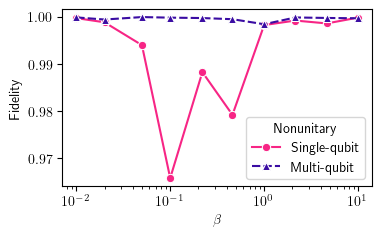

maximum Fidelity


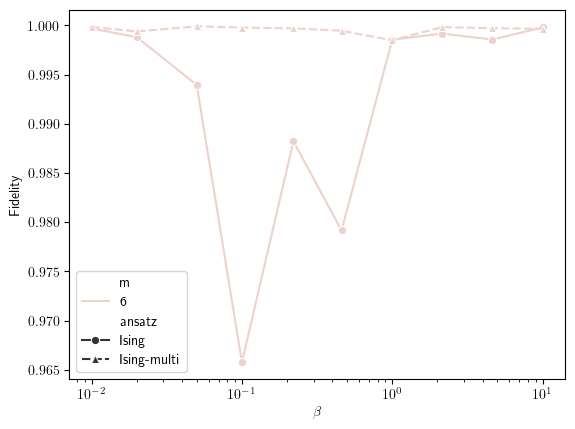

average


Text(0, 0.5, 'Fidelity')

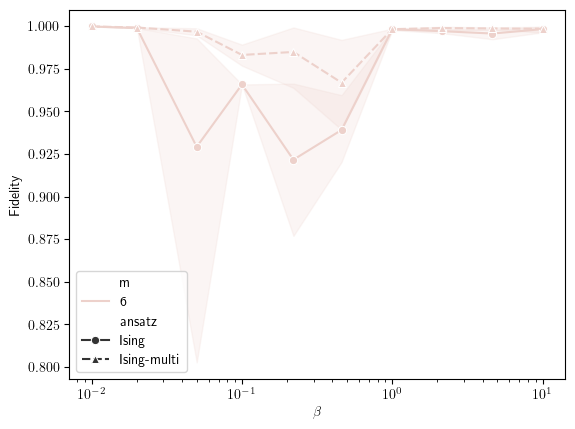

In [12]:
# plot
#beta_arr = [0.01 ,0.05, 0.1,0.2, 0.25,0.3, 0.5,0.75,1.5, 0.75, 1, 2, 5, 10,20]
df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['FinalCost'].idxmin()]
df_max = df_max[df_max['beta'].isin(beta_arr)]
plt.rcParams['text.usetex'] = True
plt.figure(figsize=(4,2.3))#(3.37, 2.0)
palette = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]
dataplot = df_max.replace(to_replace = ["Ising","Ising-multi"],value = ['Single-qubit', 'Multi-qubit'])

sns.lineplot(data = dataplot, x = 'beta', y ='F', style="ansatz",hue = "ansatz", markers=['o', '^'],palette=[palette[0],palette[2]])
plt.xscale('log')
plt.legend(title='Nonunitary')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')



filename = "Ising_exact.pdf"
plt.savefig( filename, bbox_inches='tight', facecolor=(1,1,1,0))
plt.show()
# plot
print("maximum Fidelity")
#beta_arr = [0.01 ,0.05, 0.1, 0.25,0.3, 0.5,0.75,1.5, 0.75, 1, 2, 5, 10,20]
df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['F'].idxmax()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

sns.lineplot(data = df_max, x = 'beta', y ='F', style="ansatz",hue = "m",  markers=['o', '^'],)
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

plt.show()

print("average")
sns.lineplot(data = df, x = 'beta', y ='F', style="ansatz",hue = "m", markers=['o', '^'],)
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')


In [7]:
unique_h1_values = [1]#[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
unique_h2_values = 0#"None"
h2 = 0

beta_arr =  np.around(np.exp(np.linspace(np.log(0.75),np.log(20),10)),decimals = 2)#[  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#[  0.1, 0.3,0.5, 0.75, 1, 1.5, 5, 10,20]#
h_arr = np.linspace(-1,1,10)[2:]

frames = []

N_list = [6]
m_list = [12]
model_list = ["TFIM"]
ansatz_list = ["sym_TFIM","TFIM-trotter"]#[::1]#,#"sym-TFIM-multi",
error_channel_list = ["phaseflip"]
entropy_method_list = ["approx-D"]
optimizer_list = ["L-BFGS-B"]
n_epochs_list = [50]
n_fev_list = [10000]
seeds = [1,2,3,4,5]#,3,4,5,6,7,8
multierror_list = ["no"]
initZ = "random-gaussian-small"
perr = 1e-5
h2 = 0
sym_method ="CPU"


for N in N_list:
    for m in m_list:  
                for model in model_list:
                    for ansatz in ansatz_list:
                        for error_channel in error_channel_list:
                            for entropy_method in entropy_method_list:
                                for optimizer in optimizer_list:
                                    for n_epochs in n_epochs_list:
                                        for n_fev in n_fev_list:
                                            for seed in seeds:
                                                for multierror in multierror_list:
                                                    for h1 in unique_h1_values:
                                       
                                                                frames.append(read_data(N, m, model, ansatz, error_channel, entropy_method, optimizer, n_epochs, n_fev, seed, multierror,p_err = 1e-5,tol = 1e-10,initZ=initZ,format = "full",sym_method=sym_method,h1 = h1,h2 = h2))
                                                  
                        
df = create_data_frame(frames)
df
#N_6__m_12__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_1__multiE_no__geom_normal__sym_GPU__h1_1__h2_0
#N_6__m_12__model_TFIM__ansatz_TFIM-trotter__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_1__multiE_no__geom_normal__sym_GPU__h1_1__h2_None/ 
#N_6__m_9__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_exact__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_1__multiE_no__geom_normal__sym_GPU__h1_1__h2_None/ 

Directory /Users/eliaszap/polybox - Elias Zapusek (zapuseke@phys.ethz.ch)@polybox.ethz.ch/Phd/QML/VQT/Data_grid/Data_01_09/N_6__m_12__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_1__multiE_no__geom_normal__sym_CPU__h1_1__h2_0/ does not exist.
Directory /Users/eliaszap/polybox - Elias Zapusek (zapuseke@phys.ethz.ch)@polybox.ethz.ch/Phd/QML/VQT/Data_grid/Data_01_09/N_6__m_12__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed_2__multiE_no__geom_normal__sym_CPU__h1_1__h2_0/ does not exist.
Directory /Users/eliaszap/polybox - Elias Zapusek (zapuseke@phys.ethz.ch)@polybox.ethz.ch/Phd/QML/VQT/Data_grid/Data_01_09/N_6__m_12__model_TFIM__ansatz_sym_TFIM__initZ_random-gaussian-small__errorC_phaseflip__p_err_1e-05__entropyM_approx-D__optimizer_L-BFGS-B__tol_1e-10__nShots_None__seed

ValueError: All objects passed were None

Index(['beta', 'N', 'm', 'model', 'ansatz', 'error_channel', 'entropy_method',
       'optimizer', 'n_epochs', 'n_fev', 'seed', 'multierror', 'F', 'S_cross',
       'S_cross_diff', 'TD', 'FinalCost', 'h1', 'h2'],
      dtype='object')


/var/folders/qd/5q9cvk1x2lgcx1ddzjm2j60c0000gn/T/ipykernel_12209/3455657089.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = dataplot, x = 'beta', y ='F', style="ansatz",hue="ansatz", markers=['o'],palette=[palette[3]])#,palette[2]#, '^'


TypeError: 'NoneType' object is not iterable

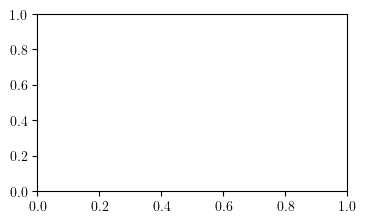

In [8]:
# plot
beta_arr =  np.around(np.exp(np.linspace(np.log(0.75),np.log(20),10)),decimals = 2)#[0.01 ,0.05, 0.1,0.2, 0.25,0.3, 0.5,0.75,1.5, 0.75, 1, 2, 5, 10,20]
df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['FinalCost'].idxmin()]
df_max = df_max[df_max['beta'].isin(beta_arr)]
palette = ["#F72585", "#7209B7", "#3A0CA3", "#4361EE", "#4CC9F0"]
plt.rcParams['text.usetex'] = True

plt.figure(figsize=(4,2.3))

df_max_12 = df_max[df_max["m"]==12]
#sns.lineplot(data =  df_max_12[df_max_12["ansatz"]=="sym_TFIM"], x = 'beta', y ='F', style="ansatz",hue="ansatz", markers=['o'],palette=[palette[3]])
#sns.lineplot(data =  df_max_12[df_max_12["ansatz"]=="TFIM-trotter"], x = 'beta', y ='F', style="ansatz",hue="ansatz", markers=['o'],palette=[palette[3]],label = r'Z'+' + Commutator')
dataplot = df_max[df_max["m"]==12].replace(to_replace = ["sym_TFIM","TFIM-trotter"],value = [r"$Z$",r"$Z$"+"+ Commutator"])#rename({"sym_TFIM":"A","TFIM-trotter":"commutator"},axis = 1)
print(dataplot.columns)
sns.lineplot(data = dataplot, x = 'beta', y ='F', style="ansatz",hue="ansatz", markers=['o'],palette=[palette[3]])#,palette[2]#, '^'
plt.xscale('log')
#plt.ylim(0.8,1)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')
plt.legend(title='Nonunitary')
filename = "TFIM_exact.pdf"
plt.savefig(filename, bbox_inches='tight', facecolor=(1,1,1,0))
plt.show()
# plot
print("maximum Fidelity")

df_max = df.loc[df.groupby(['beta', 'ansatz',"m"])['F'].idxmax()]
df_max = df_max[df_max['beta'].isin(beta_arr)]

sns.lineplot(data = df_max, x = 'beta', y ='F', style="ansatz",hue = "m",  markers=['o', '^'],)#,'.'
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')

plt.show()

print("average")
sns.lineplot(data = df, x = 'beta', y ='F', style="ansatz",hue = "m", markers=['o', '^'],)
plt.xscale('log')

plt.xlabel(r'$\beta$')
plt.ylabel(r'Fidelity')
